# Synthetic simulations with the RollerPumpCerebralModel

This notebook demonstrates the behaviour of the combined roller pump–cerebral
circulation model under static and dynamic synthetic conditions. It is meant as
a self-contained example of how to:

- construct and configure the `RollerPumpCerebralModel`,
- run static (baseline) and dynamic simulations,
- visualise pump output and cerebrovascular responses with and without cerebral autoregulation (CA).


In [30]:
# -------------------------------------------------------------------
# 0. Imports and global configuration
# -------------------------------------------------------------------
"""
This section loads all required libraries and configures global settings
used throughout the notebook.

- Matplotlib is configured to display all figures inline.
- `FIG_DIR` defines the folder where figures are saved when
  `save=True` is passed to any plotting function.
"""

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

# Display figures inside the notebook
%matplotlib inline

# -------------------------------------------------------------------
# Directory for saving figures
# -------------------------------------------------------------------
# From within the `notebooks/` directory, this path points to a folder
# placed next to the project root (e.g., for storing thesis/report figures).
FIG_DIR = Path("../Report_Figures")


## 1. Helper functions

This cell defines all utility functions used throughout the notebook:

- `rpm_series` and `extract_series` to build time series for plotting,
- `plot_fig1_and_fig3` to create the main multi-panel figures,
- `plot_compare_side_by_side` for comparing two simulations,
- simple helpers to define time-varying systemic resistance `Rs(t)`.
Run this cell once before running any simulations.


In [31]:
# 1. Helper functions
# -------------------------------------------------------------------
# Basic signal extraction and RPM helper
# -------------------------------------------------------------------

def rpm_series(model, t):
    """
    Compute pump speed in RPM as a function of time.

    Parameters
    ----------
    model : RollerPumpCerebralModel
        Model instance that provides `omega_of_t(t)` in rad/s.
    t : array-like
        1D array of time points [s].

    Returns
    -------
    rpm : np.ndarray
        1D array with pump speed [RPM] evaluated at each time point in `t`.
    """
    return np.array([model.omega_of_t(ti) * 60.0 / (2.0 * np.pi) for ti in t])


def extract_series(sol, out):
    """
    Collect commonly used state and output signals from a simulation.

    Parameters
    ----------
    sol : np.ndarray
        2D array of model state trajectories with shape (N, 9), where columns are:
        [Va_1, Va_2, Vc, Vv, iLa, iLc, phi, Va_2_mean, Rc_2_dyn].
    out : dict
        Dictionary returned by `model.simulate(...)` containing at least:
        - 'Q_out' : pump outlet flow [mL/s]
        - 'ic'    : cerebral inflow [mL/s]

    Returns
    -------
    series : dict
        Dictionary with keys:
        - "Va_1", "Va_2", "Vc", "Vv" : pressures [mmHg]
        - "iLa", "iLc"               : inertance flows [mL/s]
        - "Q_out"                    : pump outlet flow [mL/s]
        - "ic"                       : cerebral inflow [mL/s]
    """
    return {
        "Va_1":  sol[:, 0],
        "Va_2":  sol[:, 1],
        "Vc":    sol[:, 2],
        "Vv":    sol[:, 3],
        "iLa":   sol[:, 4],
        "iLc":   sol[:, 5],
        "Q_out": out["Q_out"],
        "ic":    out["ic"],
    }


# -------------------------------------------------------------------
# Plotting: single-column multi-panel figure
# -------------------------------------------------------------------

def plot_fig1_and_fig3(
    model,
    t,
    sol,
    out,
    filename="fig_pump_cerebrovascular",
    fig_title1="",
    fig_title2="",
    save=False,
    # Shading control parameters
    show_shading=False,
    Va_2_limits=(None, None),  # (lower, upper) for Va_2
    Vv_limits=(None, None),    # (lower, upper) for Vv
    ic_limits=(None, None),    # (lower, upper) for ic
    shading_alpha=0.2,         # transparency of the shading
    start_time=150.0,          # time offset in seconds
    # Optional CAR-off data
    t_off=None,                # time array for CAR-off simulation
    sol_off=None,              # solution array for CAR-off simulation
    out_off=None,              # output dict for CAR-off simulation
    # Mean value display
    show_Va2_mean=False,       # whether to show mean Va_2 value
    show_ic_mean=False,        # whether to show mean ic value
    show_subplot3=True,        # whether to show the Va2 and CVP subplot
    # Optional: draw into existing axes
    axes=None,                 # pass (ax1, ax2, ax3[, ax4]) to draw into an existing grid
    legend_loc="best",
    show_legend=True,          # hide on the left in side-by-side layouts
):
    """
    Create a multi-panel figure for pump speed, pump flow and cerebrovascular signals.

    The figure has 3 or 4 stacked subplots:
      1. RPM and pump flow (Q_out)
      2. Aortic/cerebral/venous pressures with cerebral & inertance flows
      3. (optional) Distal aortic pressure and CVP (Va_2, Vv)
      4. Cerebral inflow ic, with optional CA-on/off comparison

    Parameters
    ----------
    model : RollerPumpCerebralModel
        Model instance that provides `omega_of_t(t)` for RPM computation.
    t : array-like
        Time vector [s] for the CA-ON simulation.
    sol : np.ndarray
        State trajectories for the CA-ON simulation (output of `simulate`).
    out : dict
        Output dictionary for the CA-ON simulation (output of `simulate`).
    filename : str, optional
        Base filename (without extension) used when `save=True`.
    fig_title1 : str, optional
        Title for the first subplot (RPM and pump flow).
    fig_title2 : str, optional
        Title for the second subplot (pressures and flows).
    save : bool, optional
        If True, saves the figure as PNG and PKL to `FIG_DIR / filename`.

    Shading / target ranges
    -----------------------
    show_shading : bool, optional
        If True, draw shaded bands for target ranges.
    Va_2_limits : (float or None, float or None)
        Lower/upper limits for Va_2 shading.
    Vv_limits : (float or None, float or None)
        Lower/upper limits for Vv shading.
    ic_limits : (float or None, float or None)
        Lower/upper limits for ic shading.
    shading_alpha : float, optional
        Alpha value for shaded regions.

    Time window
    -----------
    start_time : float, optional
        Time [s] from which to start plotting (used as new t=0).

    CA-off comparison
    -----------------
    t_off : array-like or None
        Time vector [s] for the CA-OFF simulation.
    sol_off : np.ndarray or None
        State trajectories for CA-OFF.
    out_off : dict or None
        Output dictionary for CA-OFF.
        If any of these is None, CA-OFF curves are omitted.

    Mean indicators
    ---------------
    show_Va2_mean : bool, optional
        If True, draws a horizontal line at mean Va_2 in subplot 3.
    show_ic_mean : bool, optional
        If True, draws a horizontal line at mean ic in subplot 4.

    Layout control
    --------------
    show_subplot3 : bool, optional
        If True, include the Va_2/Vv subplot. If False, create only 3 rows.
    axes : sequence of matplotlib.axes.Axes or None
        If None, a new figure and axes are created.
        If given, must be a sequence of axes with length = 3 or 4, depending
        on `show_subplot3`. The function will then draw into these axes.
    legend_loc : str, optional
        Location of legends for subplots where legends are shown.
    show_legend : bool, optional
        If False, legends are suppressed (useful in side-by-side layouts).

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object containing all subplots.
    axes_tuple : tuple
        Tuple of Axes objects:
        - if show_subplot3=True: (ax1, ax2, ax3, ax4)
        - if show_subplot3=False: (ax1, ax2, ax4)
    twins : dict
        Dictionary with references to twin y-axes:
        - "row1_right" : Axes for Q_out
        - "row2_right" : Axes for flows (ic, iLa, iLc)
        - "row3_right" : None (reserved)
        - "row4_right" : None (reserved)
    """
    try:
        import mpld3  # noqa: F401
        has_mpld3 = True
    except ImportError:
        has_mpld3 = False

    ser = extract_series(sol, out)
    rpm = rpm_series(model, t)

    # Time window
    mask = t >= start_time
    t_plot = t[mask] - t[mask][0]
    ser_plot = {k: v[mask] for k, v in ser.items()}
    rpm_plot = rpm[mask]

    # Mean values (computed on the plotted window)
    if show_Va2_mean:
        Va2_mean = float(np.mean(ser_plot["Va_2"]))
    if show_ic_mean:
        ic_mean = float(np.mean(ser_plot["ic"]))

    # Optional CA-off data
    if all(x is not None for x in [t_off, sol_off, out_off]):
        mask_off = t_off >= start_time
        t_plot_off = t_off[mask_off] - t_off[mask_off][0]
        ser_off_full = extract_series(sol_off, out_off)
        ser_plot_off = {k: v[mask_off] for k, v in ser_off_full.items()}
        show_car_off = True
    else:
        show_car_off = False
        t_plot_off = None
        ser_plot_off = None

    # Figure/axes setup
    created_fig = False
    n_subplots = 4 if show_subplot3 else 3

    if axes is None:
        fig, axes = plt.subplots(
            n_subplots, 1,
            figsize=(10, 4 * n_subplots),
            sharex=True,
        )
        created_fig = True
    else:
        if len(axes) != n_subplots:
            raise ValueError(
                f"'axes' must have length {n_subplots} for show_subplot3={show_subplot3}."
            )
        fig = axes[0].figure

    # Make sure axes is indexable
    if not isinstance(axes, (list, tuple, np.ndarray)):
        axes = [axes]

    # ----------------------------------------------------------------
    # Row 1: RPM (left axis) and Q_out (right axis)
    # ----------------------------------------------------------------
    ax1 = axes[0]
    ax1.plot(t_plot, rpm_plot, label="RPM", color="#1f77b4", linewidth=2.2)
    ax1.set_ylabel("Pump angular speed [RPM]", fontsize=15, labelpad=15)
    ax1.tick_params(labelsize=12, width=2, length=8)
    ax1.grid(True, alpha=0.3)
    if fig_title1:
        ax1.set_title(fig_title1, fontsize=18, pad=12)

    ax1b = ax1.twinx()
    ax1b.plot(t_plot, ser_plot["Q_out"], "--", label="Q_out (pump)",
              color="#1f77b4", linewidth=2.2)
    ax1b.set_ylabel("Flow [mL/s]", fontsize=15, labelpad=15)
    ax1b.tick_params(labelsize=12, width=2, length=8)

    if show_legend:
        l1, n1 = ax1.get_legend_handles_labels()
        l2, n2 = ax1b.get_legend_handles_labels()
        ax1.legend(l1 + l2, n1 + n2, loc=legend_loc, fontsize=9, frameon=True)

    # ----------------------------------------------------------------
    # Row 2: Pressures (left y-axis) and flows (right y-axis)
    # ----------------------------------------------------------------
    axp = axes[1]
    axp.plot(t_plot, ser_plot["Va_1"],  label="Va_1 (prox. aortic)",  color="#d62728", linewidth=2.2)
    axp.plot(t_plot, ser_plot["Va_2"],  label="Va_2 (dist. aortic)",  color="#1f77b4", linewidth=2.2)
    axp.plot(t_plot, ser_plot["Vc"],    label="Vc (cerebral)",        color="#9467bd", linewidth=2.2)
    axp.plot(t_plot, ser_plot["Vv"],    label="Vv (venous)",          color="#ff7f0e", linewidth=2.2)
    axp.set_ylabel("Pressure [mmHg]", fontsize=15, labelpad=15)
    axp.tick_params(labelsize=12, width=2, length=8)
    axp.grid(True, alpha=0.3)
    if fig_title2:
        axp.set_title(fig_title2, fontsize=18, pad=12)

    axf = axp.twinx()
    axf.plot(t_plot, ser_plot["ic"],  "--", label="ic (cerebral flow)",
             color="#2ca02c", linewidth=2.2)
    axf.plot(t_plot, ser_plot["iLa"], "--", label="iLa (aortic inertance)",
             color="#ff7f0e", linewidth=2.2)
    axf.plot(t_plot, ser_plot["iLc"], "--", label="iLc (cerebral inertance)",
             color="#17becf", linewidth=2.2)
    axf.set_ylabel("Flow [mL/s]", fontsize=15, labelpad=15)
    axf.tick_params(labelsize=12, width=2, length=8)

    if show_legend:
        L1, lab1 = axp.get_legend_handles_labels()
        L2, lab2 = axf.get_legend_handles_labels()
        axp.legend(L1 + L2, lab1 + lab2, loc=legend_loc, fontsize=9, frameon=True)

    twins = {
        "row1_right": ax1b,
        "row2_right": axf,
        "row3_right": None,
        "row4_right": None,
    }

    # ----------------------------------------------------------------
    # Row 3 (optional): Va_2 and Vv with optional shading and mean
    # ----------------------------------------------------------------
    if show_subplot3:
        ax3 = axes[2]
        ax3.plot(t_plot, ser_plot["Va_2"], label="Va_2 (distal aortic)", color="#1f77b4", linewidth=2.2)
        ax3.plot(t_plot, ser_plot["Vv"],   label="CVP",                  color="#ff7f0e", linewidth=2.2)

        if show_shading:
            if Va_2_limits[0] is not None and Va_2_limits[1] is not None:
                ax3.axhspan(Va_2_limits[0], Va_2_limits[1],
                            color="#1f77b4", alpha=shading_alpha, label="Va_2 range")
            if Vv_limits[0] is not None and Vv_limits[1] is not None:
                ax3.axhspan(Vv_limits[0], Vv_limits[1],
                            color="#ff7f0e", alpha=shading_alpha, label="CVP range")

        if show_Va2_mean:
            ax3.axhline(y=Va2_mean, color="#1f77b4", linestyle=':', linewidth=2.2,
                        label=f"Va_2 mean ({Va2_mean:.2f} mmHg)")

        ax3.set_ylabel("Pressure [mmHg]", fontsize=15, labelpad=15)
        ax3.tick_params(labelsize=12, width=2, length=8)
        ax3.grid(True, alpha=0.3)

        if show_legend:
            ax3.legend(loc=legend_loc, fontsize=9, frameon=True)

        ax3.set_title("c) Distal aortic pressure and CVP", fontsize=18, pad=12)

    # ----------------------------------------------------------------
    # Last row: cerebral inflow ic (CA ON vs CA OFF)
    # ----------------------------------------------------------------
    last_idx = 3 if show_subplot3 else 2
    ax4 = axes[last_idx]

    ax4.plot(t_plot, ser_plot["ic"], label="ic (CA ON)", color="#2ca02c", linewidth=2.2)

    if show_ic_mean:
        ic_mean = float(np.mean(ser_plot["ic"]))
        ax4.axhline(y=ic_mean, color="#2ca02c", linestyle=':', linewidth=2.2,
                    label=f"ic mean (CA ON) ({ic_mean:.2f} mL/s)")

    if show_car_off:
        ax4.plot(t_plot_off, ser_plot_off["ic"], "--", label="ic (CA OFF)",
                 color="#d62728", linewidth=2.2, alpha=0.7)

    if show_shading and ic_limits[0] is not None and ic_limits[1] is not None:
        ax4.axhspan(ic_limits[0], ic_limits[1],
                    color="#2ca02c", alpha=shading_alpha, label="ic range")

    ax4.set_xlabel("Time [s]", fontsize=15, labelpad=15)
    ax4.set_ylabel("Flow [mL/s]", fontsize=15, labelpad=15)
    ax4.tick_params(labelsize=12, width=2, length=8)
    ax4.grid(True, alpha=0.3)

    if show_legend:
        ax4.legend(loc=legend_loc, fontsize=9, frameon=True)

    subplot_letter = "d" if show_subplot3 else "c"
    ax4.set_title(f"{subplot_letter}) Cerebral flow", fontsize=18, pad=12)

    axes[last_idx].set_xlim(left=0, right=t_plot[-1])

    # Save and show if we created the figure here
    if created_fig:
        plt.tight_layout()
        plt.show()
        if save:
            FIG_DIR.mkdir(exist_ok=True)
            fname = FIG_DIR / filename
            fig.savefig(str(fname) + ".png", dpi=300)
            with open(str(fname) + ".pkl", "wb") as f:
                pickle.dump(fig, f)
            plt.show()

    # Return figure and axes (works both for standalone and side-by-side)
    if show_subplot3:
        return fig, (ax1, axp, axes[2], ax4), twins
    else:
        return fig, (ax1, axp, ax4), twins


# -------------------------------------------------------------------
# Plotting: y-limit helper
# -------------------------------------------------------------------

def _lock_ylim(ax_left, ax_right, pad=0.05):
    """
    Synchronize y-limits of two axes with a common margin.

    Parameters
    ----------
    ax_left : matplotlib.axes.Axes
        First axes object.
    ax_right : matplotlib.axes.Axes
        Second axes object.
    pad : float, optional
        Relative padding added above and below the combined min/max.
        For example, pad=0.05 adds a 5% margin.
    """
    lo = min(ax_left.get_ylim()[0], ax_right.get_ylim()[0])
    hi = max(ax_left.get_ylim()[1], ax_right.get_ylim()[1])
    rng = hi - lo or 1.0
    ax_left.set_ylim(lo - pad * rng, hi + pad * rng)
    ax_right.set_ylim(lo - pad * rng, hi + pad * rng)


# -------------------------------------------------------------------
# Plotting: side-by-side comparison wrapper
# -------------------------------------------------------------------

def plot_compare_side_by_side(
    left_kwargs: dict,
    right_kwargs: dict,
    left_col_title: str = "Left",
    right_col_title: str = "Right",
    show_subplot3: bool = True,
):
    """
    Build a 2-column grid with 3 or 4 rows and plot two simulations side by side.

    Each column uses `plot_fig1_and_fig3` with identical layout; legends are
    typically suppressed on the left and shown on the right. Y-limits for each
    row (and corresponding twin axes) are locked to make comparisons easier.

    Parameters
    ----------
    left_kwargs : dict
        Keyword arguments for the left call to `plot_fig1_and_fig3`.
        Must NOT include `axes`, `show_subplot3`, `show_legend`, or `legend_loc`,
        as these are managed by this function.
    right_kwargs : dict
        Keyword arguments for the right call to `plot_fig1_and_fig3`.
        Same restrictions as for `left_kwargs`.
    left_col_title : str, optional
        Title displayed above the left column.
    right_col_title : str, optional
        Title displayed above the right column.
    show_subplot3 : bool, optional
        Passed through to both calls of `plot_fig1_and_fig3`; controls whether
        row 3 (Va_2 & Vv) is included.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The created figure object.
    grid : np.ndarray
        2D array of Axes objects with shape (n_rows, 2), where n_rows is 3 or 4.
    """
    n_rows = 4 if show_subplot3 else 3
    fig, grid = plt.subplots(
        n_rows, 2,
        figsize=(16, 4.2 * n_rows),
        sharex="col",
    )

    # Left column (no legends)
    lk = dict(left_kwargs)
    lk.update(
        dict(
            show_subplot3=show_subplot3,
            axes=tuple(grid[r, 0] for r in range(n_rows)),
            show_legend=False,
        )
    )
    _, axsL, twinsL = plot_fig1_and_fig3(**lk)

    # Right column (legends in upper right)
    rk = dict(right_kwargs)
    rk.update(
        dict(
            show_subplot3=show_subplot3,
            axes=tuple(grid[r, 1] for r in range(n_rows)),
            legend_loc="upper right",
            show_legend=True,
        )
    )
    _, axsR, twinsR = plot_fig1_and_fig3(**rk)

    # Column headers (separate titles for left and right)
    fig.text(0.25, 0.995, left_col_title,
             ha="center", va="top", fontsize=14, weight="bold")
    fig.text(0.75, 0.995, right_col_title,
             ha="center", va="top", fontsize=14, weight="bold")

    # Lock primary y-lims per row
    if show_subplot3:
        _lock_ylim(grid[0, 0], grid[0, 1])  # RPM
        _lock_ylim(grid[1, 0], grid[1, 1])  # pressures
        _lock_ylim(grid[2, 0], grid[2, 1])  # Va2 & Vv
        _lock_ylim(grid[3, 0], grid[3, 1])  # ic

        # Lock twin y-lims (Q_out and inertance/cerebral flows)
        if twinsL["row1_right"] is not None and twinsR["row1_right"] is not None:
            _lock_ylim(twinsL["row1_right"], twinsR["row1_right"])
        if twinsL["row2_right"] is not None and twinsR["row2_right"] is not None:
            _lock_ylim(twinsL["row2_right"], twinsR["row2_right"])
    else:
        _lock_ylim(grid[0, 0], grid[0, 1])  # RPM
        _lock_ylim(grid[1, 0], grid[1, 1])  # pressures
        _lock_ylim(grid[2, 0], grid[2, 1])  # ic

        if twinsL["row1_right"] is not None and twinsR["row1_right"] is not None:
            _lock_ylim(twinsL["row1_right"], twinsR["row1_right"])
        if twinsL["row2_right"] is not None and twinsR["row2_right"] is not None:
            _lock_ylim(twinsL["row2_right"], twinsR["row2_right"])

    fig.tight_layout(rect=[0, 0, 1, 0.985])  # leave room for column headers
    return fig, grid


# -------------------------------------------------------------------
# Resistance schedule helpers
# -------------------------------------------------------------------

def make_Rs_const(Rs_value):
    """
    Create a time-independent systemic resistance function Rs(t).

    Parameters
    ----------
    Rs_value : float
        Constant value of systemic resistance [mmHg·s/mL].

    Returns
    -------
    f : callable
        Function `f(t)` that accepts either a scalar or array-like `t` and
        returns an array (or scalar) filled with `Rs_value`.
    """
    Rs_value = float(Rs_value)

    def f(t):
        try:
            tt = np.asarray(t, float)
            return np.zeros_like(tt) + Rs_value
        except Exception:
            return Rs_value

    return f


def make_Rs_of_t(t_knots, Rs_knots, mode="linear"):
    """
    Create a time-varying systemic resistance function Rs(t) from knot data.

    Parameters
    ----------
    t_knots : array-like
        1D array of strictly increasing time points [s].
    Rs_knots : array-like
        1D array of Rs values [mmHg·s/mL] at each knot in `t_knots`.
        Must have the same length as `t_knots`.
    mode : {"linear", "zoh"}, optional
        Interpolation mode:
        - "linear": piecewise linear interpolation between knots.
        - "zoh":    zero-order hold (piecewise constant, step-wise).

    Returns
    -------
    f : callable
        Function `f(t)` that returns Rs at time `t`. For:
        - mode="linear": uses `np.interp`.
        - mode="zoh":    holds the last knot value until the next knot.

    Raises
    ------
    ValueError
        If `t_knots` is not strictly increasing or `mode` is unsupported.
    """
    t_knots = np.asarray(t_knots, float)
    Rs_knots = np.asarray(Rs_knots, float)

    if np.any(np.diff(t_knots) <= 0):
        raise ValueError("t_knots must be strictly increasing.")

    if mode == "linear":
        return lambda t: float(np.interp(t, t_knots, Rs_knots))

    elif mode == "zoh":
        def f(t):
            i = np.searchsorted(t_knots, t, side="right") - 1
            i = int(np.clip(i, 0, len(t_knots) - 1))
            return float(Rs_knots[i])
        return f

    else:
        raise ValueError("mode must be 'linear' or 'zoh'.")


## 2. Import the model package

Here we load the `RollerPumpCerebralModel` from the local Python package.
The code assumes that this notebook lives in a `notebooks/` folder and that
the package is available in `../src/roller_pump_cerebral_model`.


In [32]:
# 2. Import the model package

# -------------------------------------------------------------------
# (1) Enable autoreload for convenient development
# -------------------------------------------------------------------
%load_ext autoreload
%autoreload 2

# -------------------------------------------------------------------
# (2) Ensure the project’s src directory is on the Python path
# -------------------------------------------------------------------
import sys
from pathlib import Path

project_root = Path().resolve().parents[0]
src_path = project_root / "src"

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# -------------------------------------------------------------------
# (3) Import the main model class
# -------------------------------------------------------------------
from roller_pump_cerebral_model import RollerPumpCerebralModel



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 3. Static baseline: "average neonate undergoing CPB"

We first define an "average neonate undergoing CPB" and run a static baseline
simulation at constant pump speed. Target values are the overall mean arterial
blood pressure (ABP), cerebral blood flow (CBF) and central venous pressure (CVP).

Internal hemodynamic parameters were initially derived from adult computational
cerebral circulation models and then adjusted to visually match these targets. The CAR
parameters are chosen so that they do not change the haemodynamics at this
baseline pump speed.


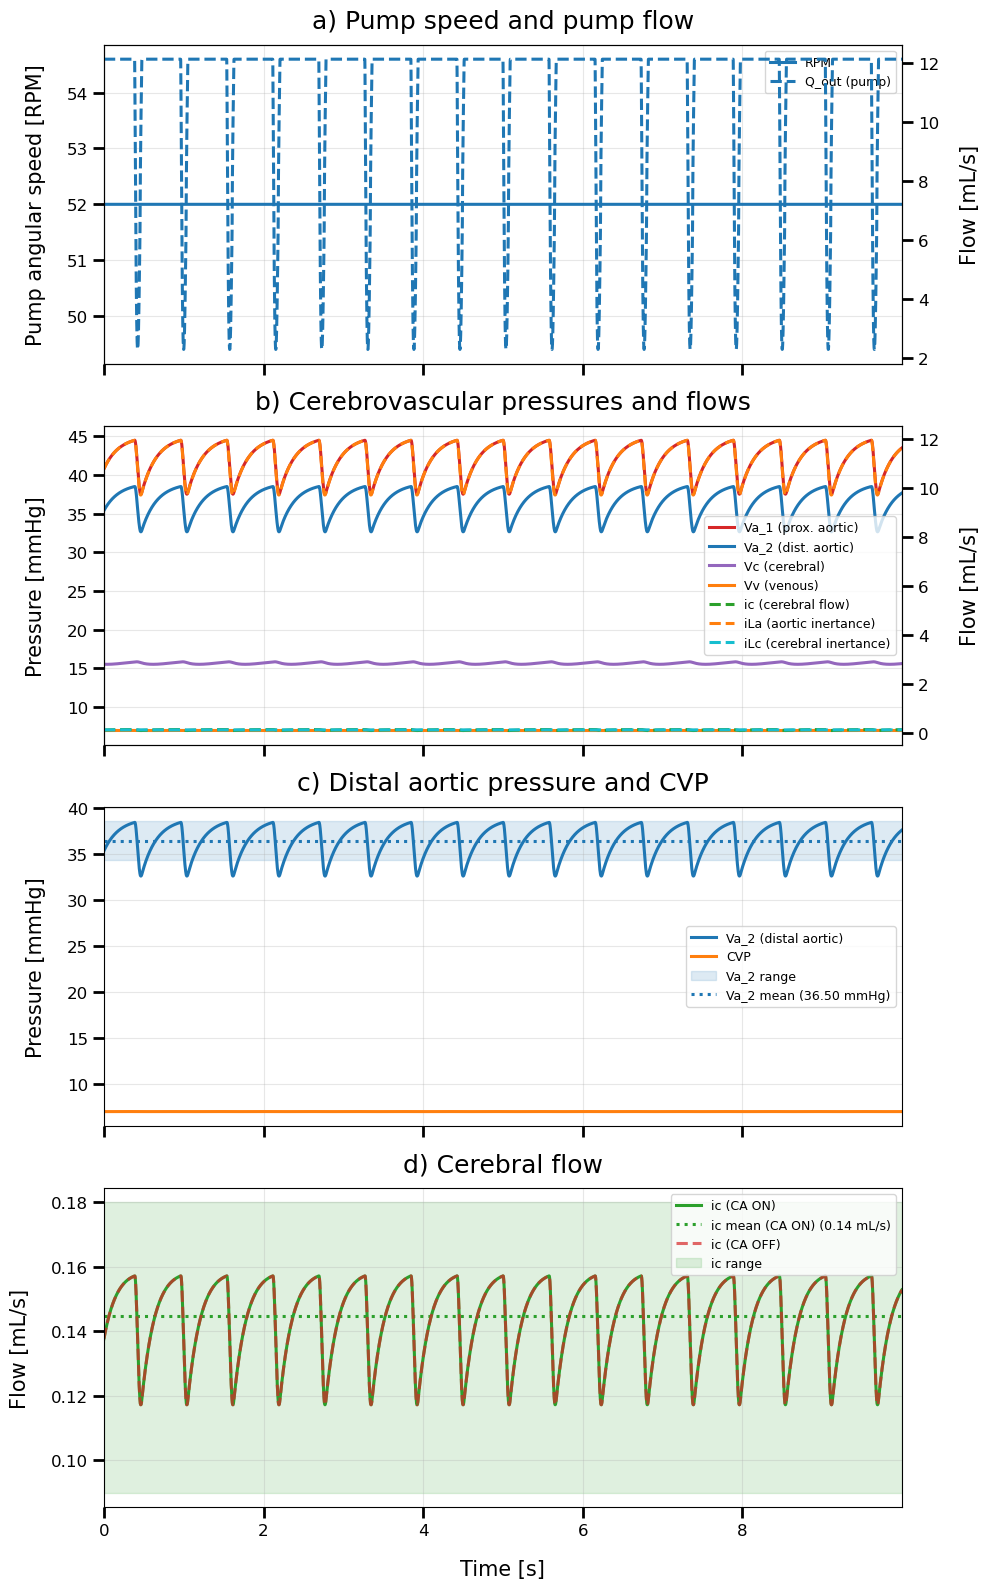

In [33]:
# 3. Static baseline simulation at constant RPM

# -------------------------------------------------------------------
# (1) Create the model and define constant pump speed
# -------------------------------------------------------------------
model = RollerPumpCerebralModel(dt=1e-3)   # 1 ms step size

t_cmd = [
    0.0,    # start
    120.0,  # end (constant throughout)
]

rpm_cmd = [
    52.0,   # overall mean RPM (constant)
    52.0,
]

model.set_rpm_schedule(
    t_cmd,
    rpm_cmd,
    mode="linear",
)

# -------------------------------------------------------------------
# (2) Load hemodynamic parameters for an 
#     "average neonate undergoing CPB"
# -------------------------------------------------------------------
model.load_preset("average_final")

# Example: how to modify a parameter (user-editable)
# model.hemo.Ca_1 = 0.02   # aortic compliance at Va_1 [mL/mmHg]

# -------------------------------------------------------------------
# (3) Define initial state close to steady state
#     → reduces warm-up time
# -------------------------------------------------------------------
y0 = np.array([
    42.0,               # Va_1 [mmHg]
    36.5,              # Va_2 [mmHg]
    7.1,               # Vc   [mmHg]
    7.0,               # Vv   [mmHg]
    11.5,              # iLa  [mL/s]
    0.2,               # iLc  [mL/s]
    0.0,               # phi  [rad]
    36.5,              # Va_2_mean [mmHg]
    model.hemo.Rc_2,   # Rc_2_dyn [mmHg·s/mL]
])

# -------------------------------------------------------------------
# (4) Run baseline simulation with CA enabled and disabled
# -------------------------------------------------------------------
T_sim = 50.0  # total simulation time [s]

t, sol, out = model.simulate(
    T=T_sim,
    y0=y0,
    car_enable=True,
)

t_off, sol_off, out_off = model.simulate(
    T=T_sim,
    y0=y0,
    car_enable=False,
)

# -------------------------------------------------------------------
# (5) Plot baseline pressures, flows, and pump output
# -------------------------------------------------------------------
fig_baseline = plot_fig1_and_fig3(
    model=model,
    t=t, sol=sol, out=out,
    t_off=t_off, sol_off=sol_off, out_off=out_off,
    filename="fig_static_baseline",
    fig_title1="a) Pump speed and pump flow",
    fig_title2="b) Cerebrovascular pressures and flows",
    save=False,                    # set True to save in FIG_DIR
    show_shading=True,
    Va_2_limits=(34.4, 38.6),      # example pressure range
    Vv_limits=(None, None),
    ic_limits=(0.09, 0.18),        # expected cerebral flow range
    shading_alpha=0.15,
    start_time=40.0,
    show_Va2_mean=True,
    show_ic_mean=True,
)


## 4. Dynamic simulation 1: increasing pump speed

Next, we increase the pump speed from its baseline value to twice that value
over 2 seconds and then keep it constant. This is used to assess the modelled
cerebral autoregulation (CA):

- without CA, CBF is expected to be pressure-passive and rise with ABP/RPM;
- with intact CA, CBF should show a transient perturbation and then return
  towards a lower baseline than in the simulation without CA despite the higher ABP.


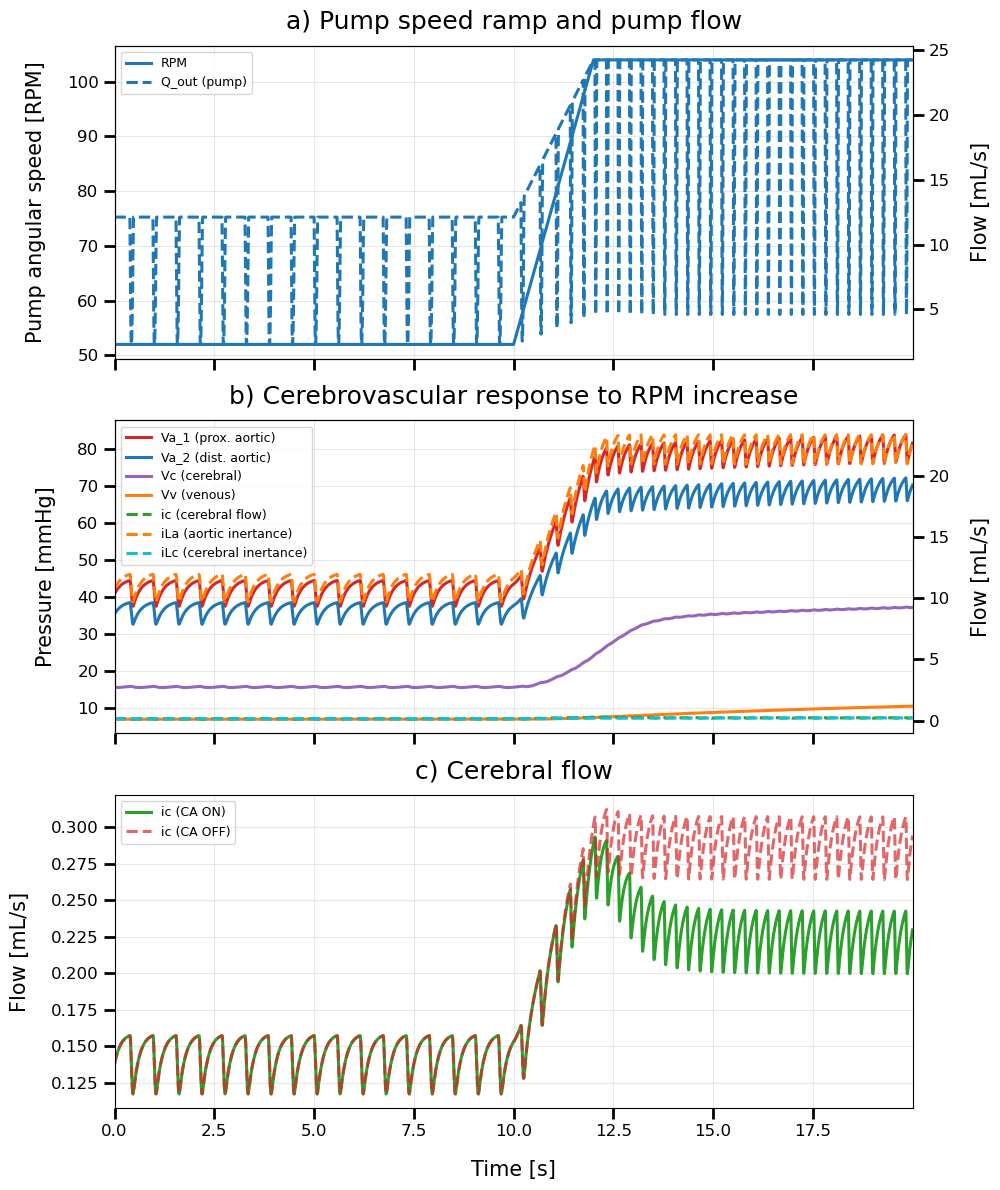

In [34]:
# 4. Dynamic simulation 1: RPM ramp

# -------------------------------------------------------------------
# (1) Define pump speed schedule: baseline → 2× baseline in 2 seconds
# -------------------------------------------------------------------
t_cmd_ramp = [
    0.0,   # baseline phase
    50.0,  # still baseline
    52.0,  # rapid ramp up
    62.0,  # hold at higher speed
]

rpm_cmd_ramp = [
    52.0,   # baseline RPM
    52.0,   # baseline RPM
    104.0,  # 2× baseline
    104.0,  # hold at 2× baseline
]

model.set_rpm_schedule(
    t_cmd_ramp,
    rpm_cmd_ramp,
    mode="linear",
)

# -------------------------------------------------------------------
# (2) Run simulations with CA enabled and disabled
# -------------------------------------------------------------------
t_rpm, sol_rpm, out_rpm = model.simulate(
    T=60.0,
    y0=y0,
    car_enable=True,
)

t_rpm_off, sol_rpm_off, out_rpm_off = model.simulate(
    T=60.0,
    y0=y0,
    car_enable=False,
)

# -------------------------------------------------------------------
# (3) Plot the response using your standard multi-panel figure
# -------------------------------------------------------------------
fig_rpm = plot_fig1_and_fig3(
    model=model,
    t=t_rpm, sol=sol_rpm, out=out_rpm,
    t_off=t_rpm_off, sol_off=sol_rpm_off, out_off=out_rpm_off,
    filename="fig_dynamic_rpm_ramp",
    fig_title1="a) Pump speed ramp and pump flow",
    fig_title2="b) Cerebrovascular response to RPM increase",
    save=False,          # set to True to save
    show_shading=False,
    start_time=40.0,
    show_subplot3=False,
)

## 5. Dynamic simulation 2: increasing systemic vascular resistance

In this simulation the pump speed is kept constant at the overall mean value
while the systemic vascular resistance Rs is increased linearly by 25% over
2 seconds and then held constant. ABP is expected to rise with Rs.

Again, we compare simulations with and without CA:
- without CA, CBF should rise with the increased ABP;
- with CA active, CBF is expected to return towards a lower value than in the simulation without CA.


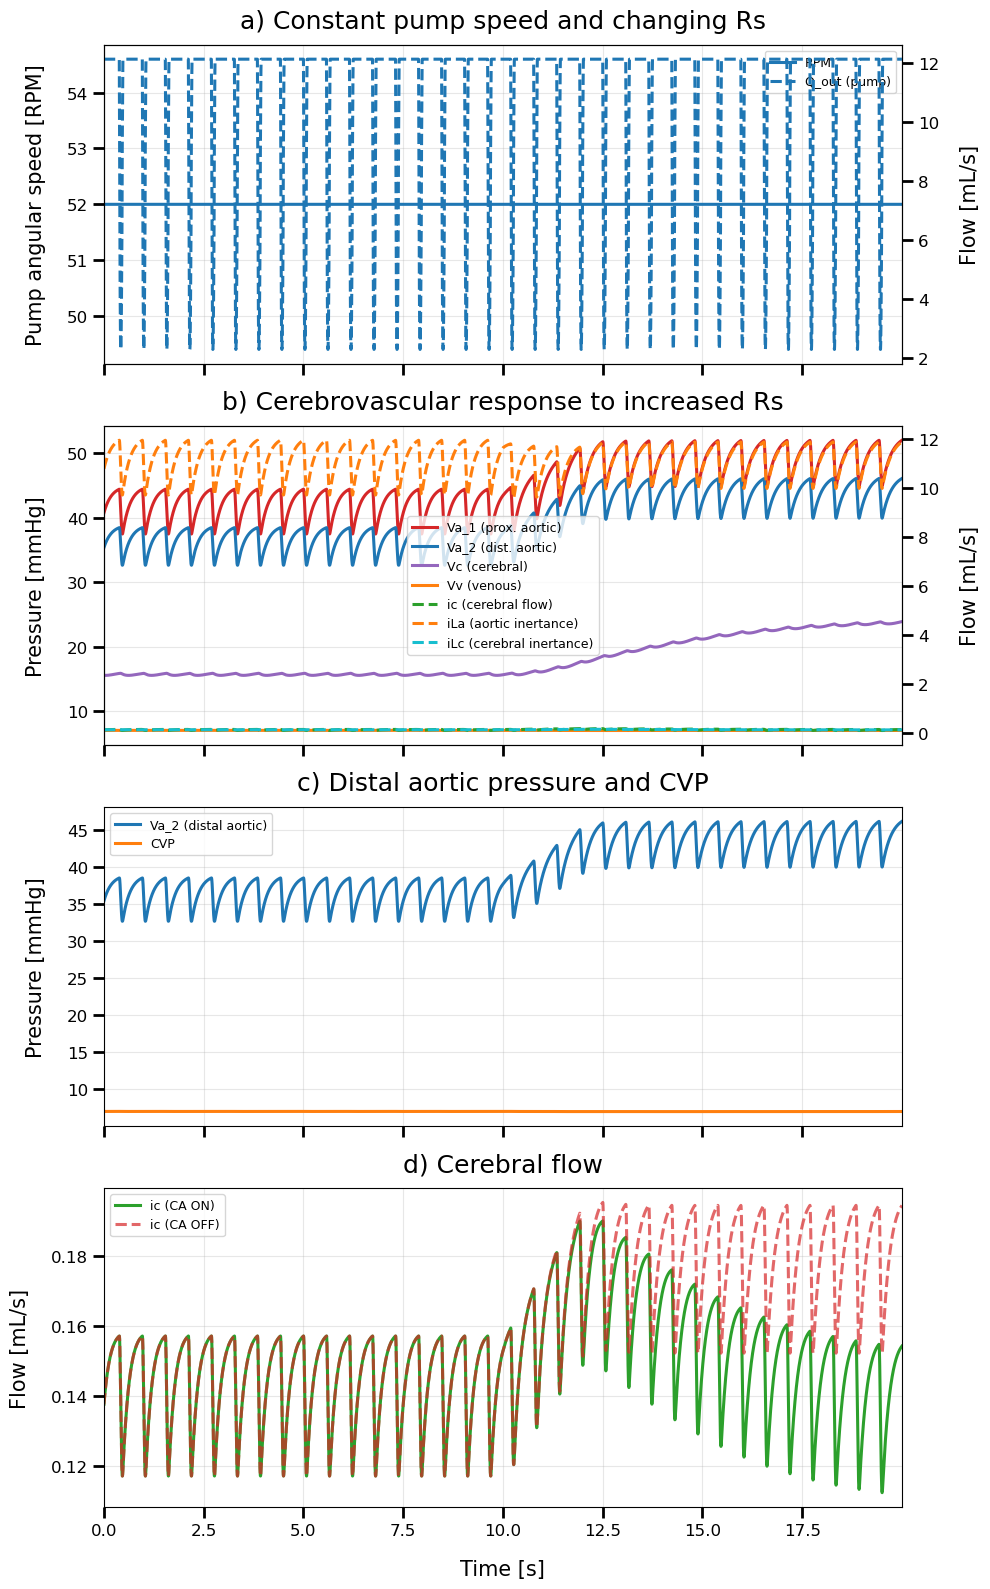

In [35]:
# 5. Dynamic simulation 2: Rs ramp
# -------------------------------------------------------------------
# (1) Define constant pump speed (baseline)
# -------------------------------------------------------------------
t_cmd_const = [0.0, 120.0]
rpm_cmd_const = [52.0, 52.0]          # constant pump speed
model.set_rpm_schedule(t_cmd_const, rpm_cmd_const, mode="linear")

# -------------------------------------------------------------------
# (2) Define Rs(t): 25% increase over 5 seconds, then hold
# -------------------------------------------------------------------
Rs_base = 2.6735

t_knots = [
    0.0,     # baseline
    50.0,    # unchanged
    52.0,    # rapid increase
    120.0,   # stable at elevated level
]

Rs_knots = [
    Rs_base,            # baseline
    Rs_base,            # still baseline
    Rs_base * 1.25,     # +25% over 2s
    Rs_base * 1.25,     # hold
]

Rs_of_t = make_Rs_of_t(
    t_knots,
    Rs_knots,
    mode="linear"
)

# -------------------------------------------------------------------
# (3) Run simulations with CA enabled and disabled
# -------------------------------------------------------------------
t_Rs, sol_Rs, out_Rs = model.simulate(
    T=60.0,
    y0=y0,
    car_enable=True,
    Rs_of_t=Rs_of_t,
)

t_Rs_off, sol_Rs_off, out_Rs_off = model.simulate(
    T=60.0,
    y0=y0,
    car_enable=False,
    Rs_of_t=Rs_of_t,
)

# -------------------------------------------------------------------
# (4) Plot results using your multi-panel figure setup
# -------------------------------------------------------------------
fig_Rs = plot_fig1_and_fig3(
    model=model,
    t=t_Rs, sol=sol_Rs, out=out_Rs,
    t_off=t_Rs_off, sol_off=sol_Rs_off, out_off=out_Rs_off,
    filename="fig_dynamic_Rs_ramp",
    fig_title1="a) Constant pump speed and changing Rs",
    fig_title2="b) Cerebrovascular response to increased Rs",
    save=False,        # set to True to save in FIG_DIR
    show_shading=False,
    start_time=40.0,
)


## 6. Dynamic simulation 3: slow RPM ramp and CA illustration

In this simulation the pump speed is ramped linearly over one minute to 
generate a gradually rising arterial pressure. The model is run twice again:

- with CA inactive, to show pressure-passive CBF,
- with CA active, after tuning the CA parameters so that the lower and upper
   autoregulatory limits fall within a physiologically plausible ABP range.

By plotting CBF versus ABP, this setup can produce a Lassen-type 
autoregulation curve, with a plateau between two inflection points.

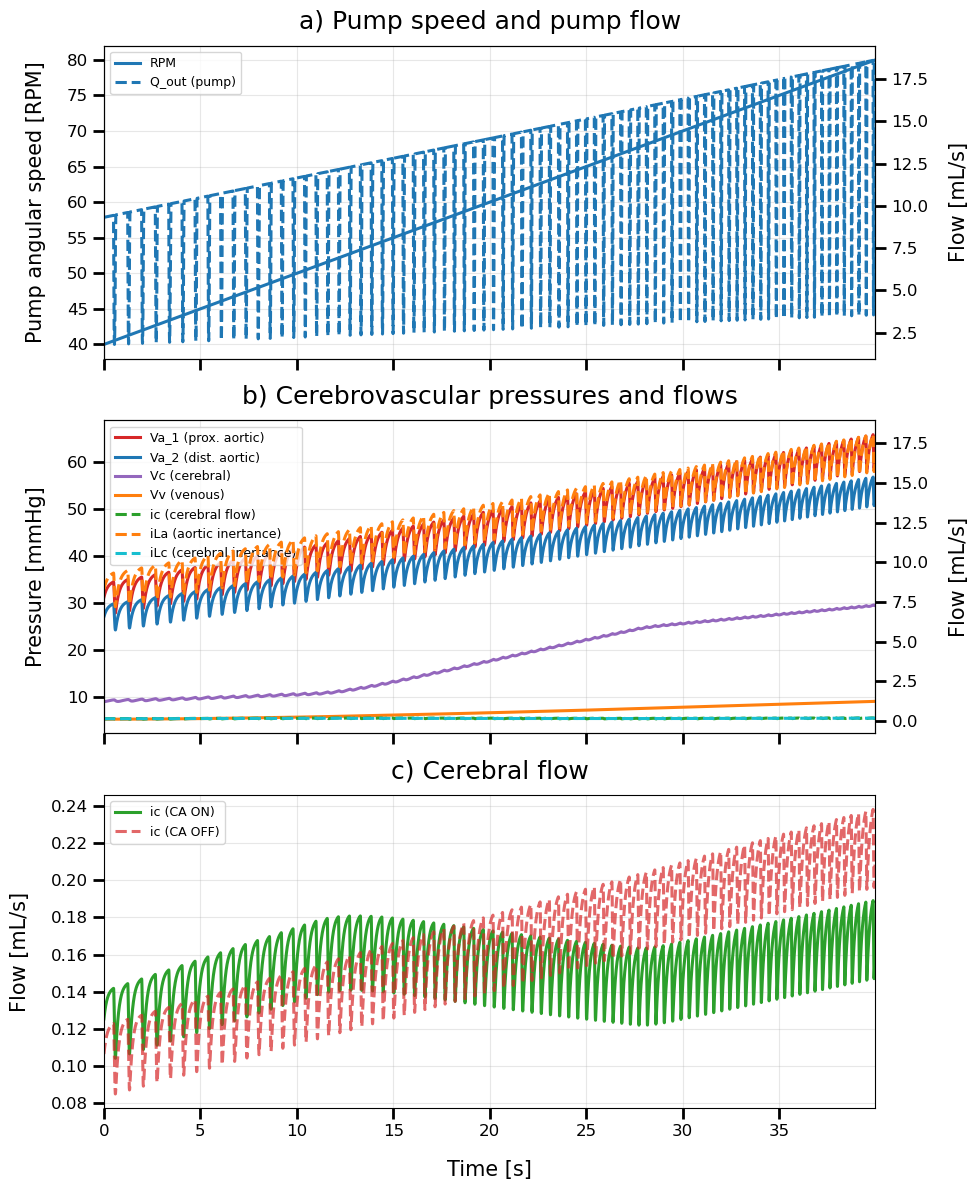

In [36]:
# 6. Dynamic simulation: short RPM ramp with tuned CA parameters

# -------------------------------------------------------------------
# (1) Define a short RPM ramp: 40 RPM → 80 RPM between 40 and 80 seconds
# -------------------------------------------------------------------
t_cmd = [0.0, 40.0, 80.0]   # time points [s]
rpm_cmd = [40.0, 40.0, 80.0]  # corresponding pump speeds [RPM]

m_test = RollerPumpCerebralModel(dt=1e-3)

# Use the "average_final" preset as hemodynamic baseline
m_test.load_preset("average_final")

# Apply the RPM schedule
m_test.set_rpm_schedule(t_cmd, rpm_cmd, mode="linear")

# -------------------------------------------------------------------
# (2) Tune CA (CAR) parameters – example of how to change them
# -------------------------------------------------------------------
# Sensitivity of Rc_2 to the mean pressure error (S):
#m_test.car.SRc_2 = 0.08


# -------------------------------------------------------------------
# (3) Run simulations with CA enabled and disabled
# -------------------------------------------------------------------
T_sim = 80.0

t, sol, out = m_test.simulate(T=T_sim, car_enable=True)
t_off, sol_off, out_off = m_test.simulate(T=T_sim, car_enable=False)

# -------------------------------------------------------------------
# (4) Plot using your existing multi-panel figure function
# -------------------------------------------------------------------
fig = plot_fig1_and_fig3(
    m_test,
    t, sol, out,
    filename="Figure_constant_RPM_short_ramp",
    fig_title1="a) Pump speed and pump flow",
    fig_title2="b) Cerebrovascular pressures and flows",
    save=False,              # set to True to save in FIG_DIR
    show_shading=False,
    start_time=40.0,         # focus on the ramp phase
    t_off=t_off,
    sol_off=sol_off,
    out_off=out_off,
    show_subplot3=False,
)